In [1]:
# Imports
from IPython.display import display, HTML

def setup_display(width=95, fontsize=16):
    """
    Sets window width and markdown fontsize for Jupyter notebook. Width is % of window.
    """
    display(HTML("<style>.container { width:"+str(width)+"% !important; }</style>"))
    display(HTML("<style>.rendered_html { font-size: "+str(fontsize)+"px; }</style>"))
    return None

def source(fn):
    import inspect
    print(inspect.getsource(fn))
    return None

import numpy as np
import glob
import winnie
from winnie.plot import animate_quick_implot, quick_implot, mpl, plt
from spaceKLIP import database
import webbpsf
import astropy.units as u

plt.style.use('winnie.winnie_mplstyle') # Comment this out or replace it if you prefer a different plot style

setup_display()

In [2]:
# Prep the SpaceRDI object:
distance = 9.714 # Distance to your target in parsecs

base_dir = './aumic_rdi_example/'
input_dir = f'{base_dir}coadded/'
data_ext = 'calints'
fitsfiles = np.sort(glob.glob(f'{input_dir}*{data_ext}.fits')) # Populate a file list

# Initialize the spaceKLIP database
Database = database.Database(base_dir)
Database.verbose = False
Database.read_jwst_s012_data(datapaths=fitsfiles)

# Create the SpaceRDI object we'll use to carry out RDI
wdb = winnie.SpaceRDI(Database, output_subdir='WinnieRDI', overwrite=True, verbose=True, pad_data='auto')

In [3]:
wdb.load_concat(0)

JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Mode: RDI (Winnie)
Extension for output files: 'rdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Mode: RDI (Winnie)
Extension for output files: 'rdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


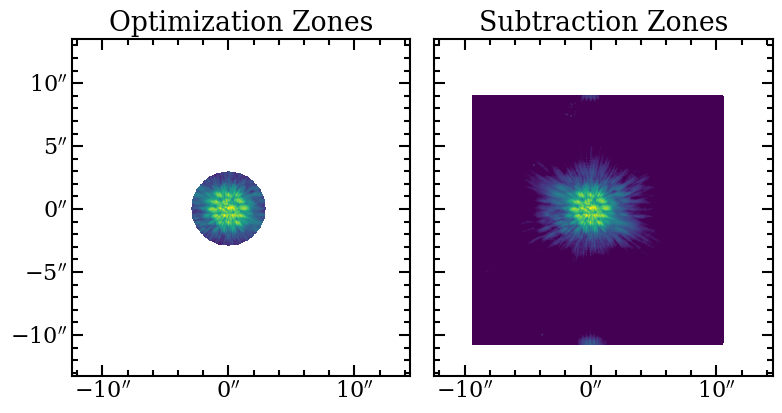

In [4]:
# Use the following to report some info about the current configuration and make plots showing the subtraction vs optimization regions being used
wdb.report_current_config(show_plots=True)

If you're used to working with KLIP (or classical RDI), optimization and subtraction zones may not be a familiar concept.

Optimization and subtraction zones are used to construct our stellar PSF model for PSF subtraction.

Optimization zones: the regions in which the science and reference images are compared to determine the reference image coefficients to be used in the stellar PSF model.

Subtraction zones: the regions in which the stellar PSF model is constructed using the coefficients from the corresponding optimization region. 

By default, load_concat will set SpaceRDI to use a single zone each for optimization and subtraction — using r < 3 arcsec for optimization, and the full frame for subtraction. Since very little stellar flux (comparatively) is present beyond ~3 arcsec, this simply speeds up the calculation while avoiding contributions from background sources.

If you'd like different zones to be used by default when a concatenation is loaded, you can set the "r_opt" and/or "r_sub" arguments when initializing the SpaceRDI object, or you can set the r_opt and r_sub attributes directly anytime thereafter (e.g., wdb.r_opt). Just keep in mind that if you already loaded a concat, you'll either need to reload it or manually update the optimization/subtraction zones.

```
wdb.r_opt = 5*u.arcsec

wdb.update_annular_zones()
```

In [5]:
# Run RDI using the current settings

rdi_reduc = wdb.run_rdi()

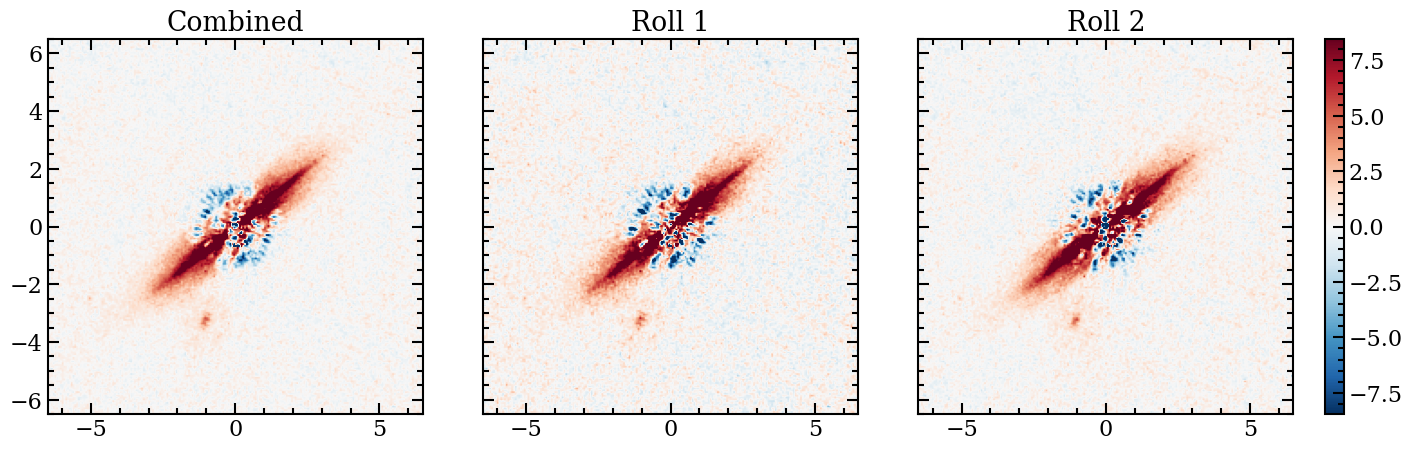

In [6]:
fig,axes,cbar = quick_implot([rdi_reduc.im, *rdi_reduc.rolls], show=False, clim_perc=99.5, cmap='RdBu_r', extent=rdi_reduc.extent, show_ticks=True, lims=[-6.5,6.5],
                              cbar=True, cbar_kwargs=dict(pad=0.02), panelsize=(5.5,4.5))

for i,label in enumerate(['Combined', 'Roll 1', 'Roll 2']):
    axes[i].set_title(label)
    
plt.show()

Let's try breaking our PSF subtraction into concentric annuli.

The subtraction zones will be 20 pixels wide radially, while the optimization zones are centered radially on the subtraction zones with widths of 40 pixels instead.

JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Mode: RDI (Winnie)
Extension for output files: 'rdi_psfsub'
8 optimization zone(s)
8 subtraction zone(s)


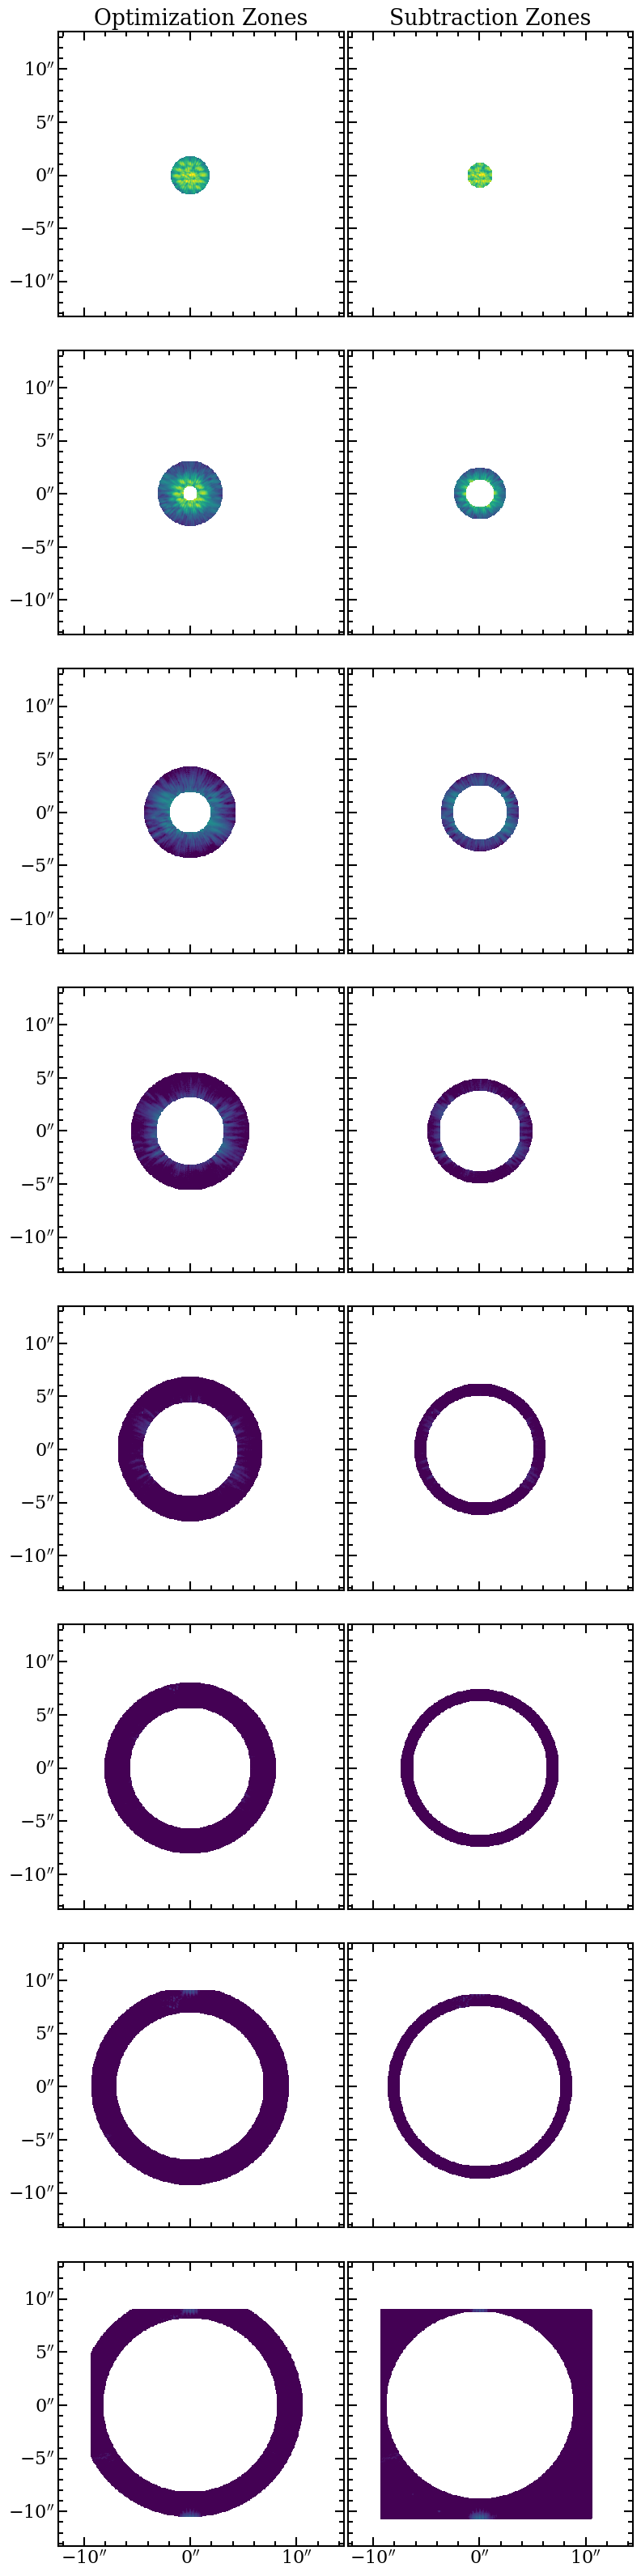

In [7]:
dr = 20
r1_sub = np.arange(0,160,dr)
r2_sub = r1_sub+dr

wdb.r_sub = np.array([r1_sub, r2_sub]).T
wdb.r_opt = np.array([r1_sub-10, r2_sub+10]).T

wdb.update_annular_zones()

wdb.report_current_config(show_plots=True)

In [8]:
rdi_reduc2 = wdb.run_rdi()

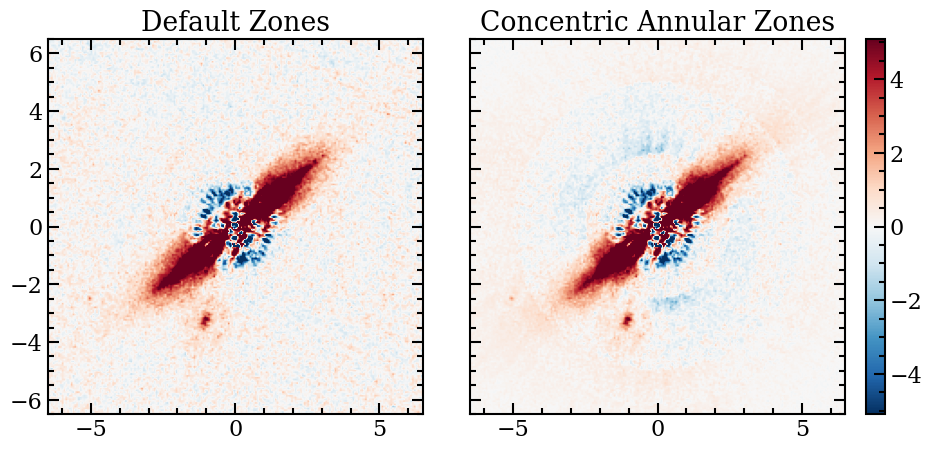

In [9]:
fig,axes,cbar = quick_implot([rdi_reduc.im, rdi_reduc2.im], show=False, clim_perc=99, cmap='RdBu_r', extent=rdi_reduc.extent, show_ticks=True, lims=[-6.5,6.5],
                              cbar=True, cbar_kwargs=dict(pad=0.02), panelsize=(5.5,4.5))

for i,label in enumerate(['Default Zones', 'Concentric Annular Zones']):
    axes[i].set_title(label)
    
plt.show()

You can use any arbitrary arrangement of optimization and subtraction zones so long as:

   a) you have the same number of each, and
   
   b) no pixel is included in multiple subtraction zones; i.e., np.all(np.sum(subzones, axis=0) <= 1) should be True. As in the example above, your optimization regions CAN overlap.
   
**NOTE**: the set_zones method (and thus the update_annular_zones method) will raise an error if b) is not true.

Any pixels that are not included in any subtraction zone will be NaN in the PSF model, and so NaN in the final image. winnie.rdi.build_annular_rdi_zones will automatically add any such pixels to the final subtraction zone.

### "ANY arbitrary arrangement?"

### Yes:

JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Mode: RDI (Winnie)
Extension for output files: 'rdi_psfsub'
8 optimization zone(s)
8 subtraction zone(s)


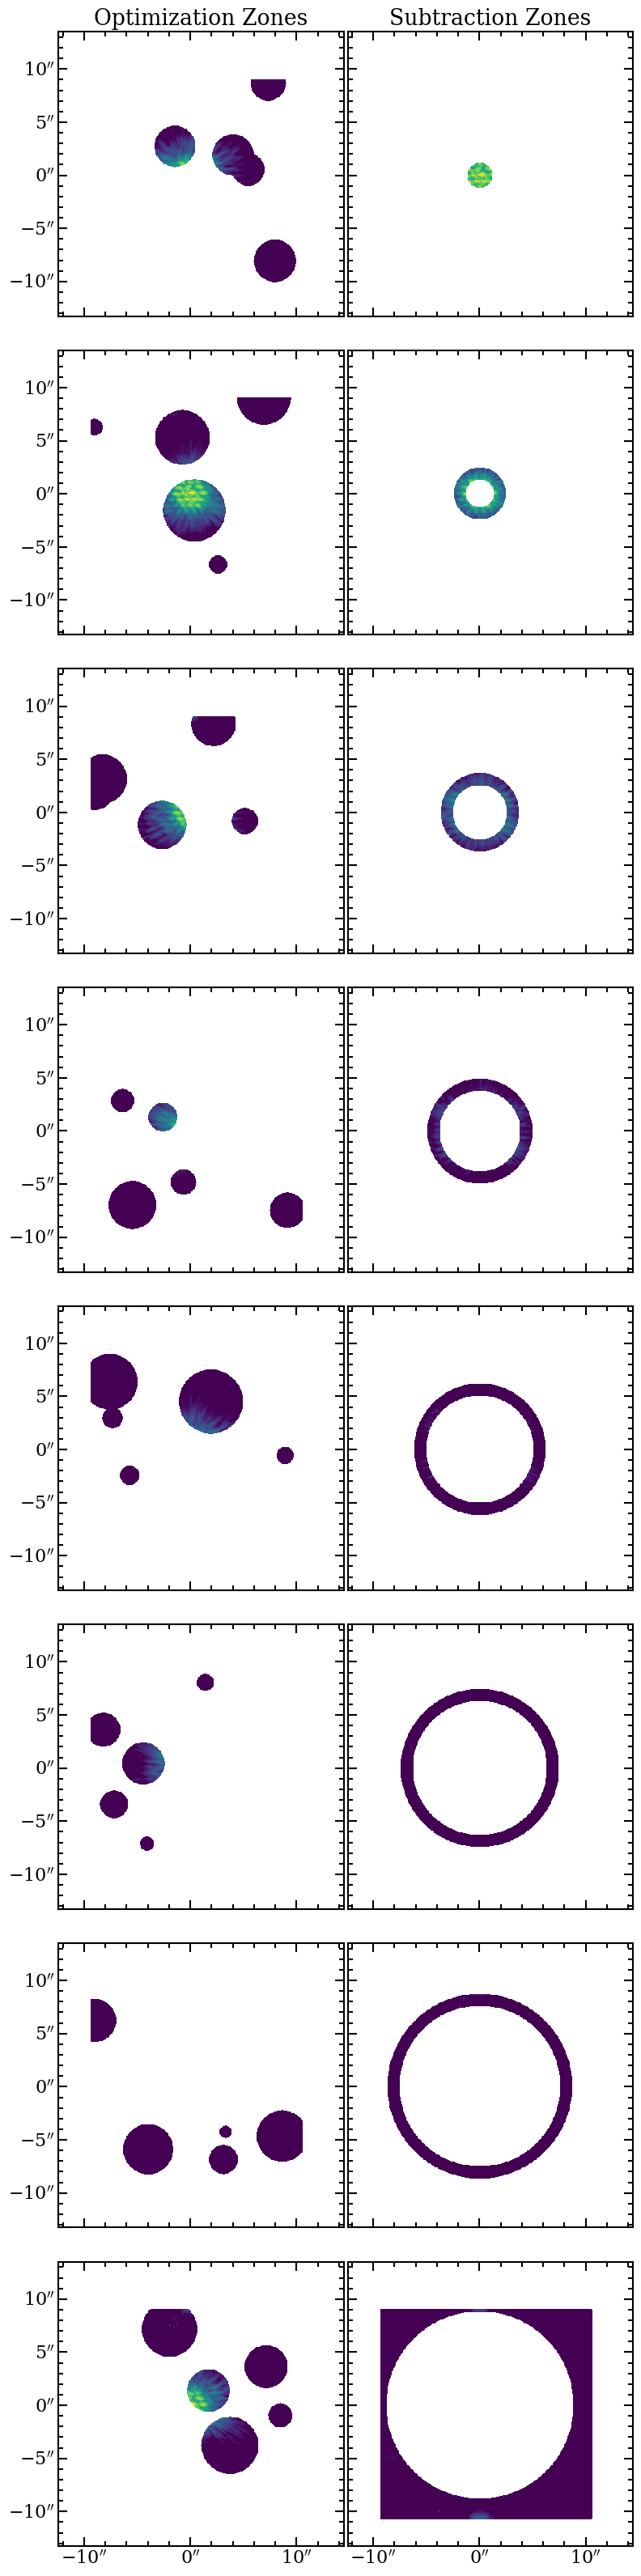

In [10]:
# Set each optimization zone to include pixels within 5 randomly placed circles (of random radius)
# Here, our zones are more complicated than simple annular zones from before, so we construct full boolean arrays
# and set them using the set_zones method

np.random.seed(0)

vmax = 150
subzones = wdb.subzones
optzones = np.zeros_like(subzones)
nCirc = 5
for i in range(subzones.shape[0]):
    for _ in range(nCirc):
        rmax = np.random.uniform(10,50)
        x, y = np.random.uniform(-vmax, vmax, size=2) + wdb.c_star
        optzones[i] = np.logical_or(optzones[i], winnie.utils.dist_to_pt([x,y], wdb.nx, wdb.ny) <= rmax)

wdb.set_zones(optzones, subzones)

wdb.report_current_config(show_plots=True)

In [11]:
rdi_reduc3 = wdb.run_rdi()

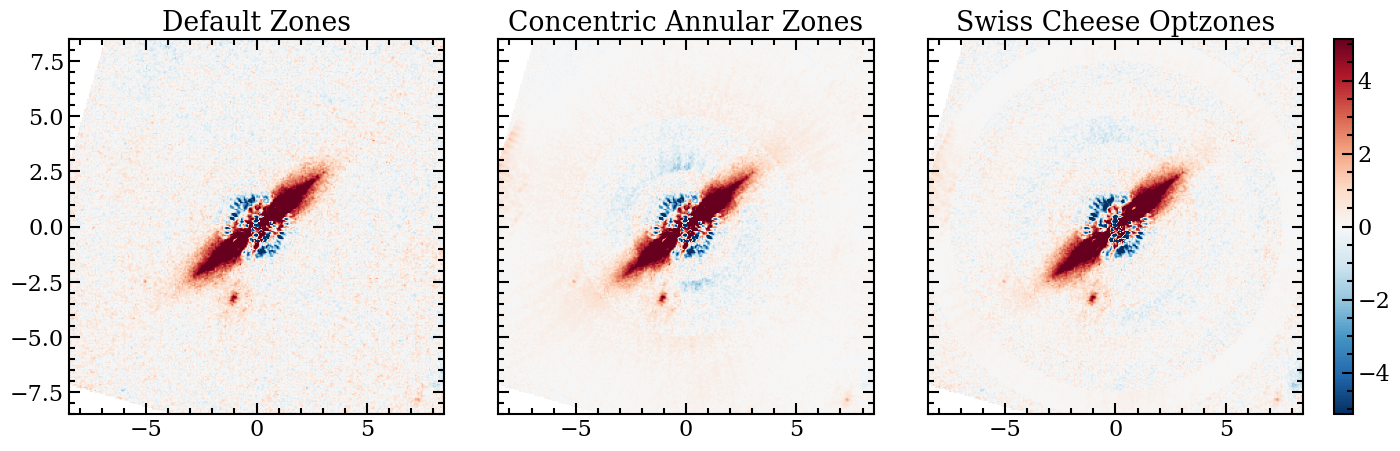

In [12]:
fig,axes,cbar = quick_implot([rdi_reduc.im, rdi_reduc2.im, rdi_reduc3.im], show=False, clim_perc=99, cmap='RdBu_r', extent=rdi_reduc.extent, show_ticks=True, lims=[-8.5,8.5],
                              cbar=True, cbar_kwargs=dict(pad=0.02), panelsize=(5.5,4.5))

for i,label in enumerate(['Default Zones', 'Concentric Annular Zones', 'Swiss Cheese Optzones']):
    axes[i].set_title(label)
    
plt.show()

Please note that when loading a new concatenation with the load_concat method, any custom optimization/subtraction zones set using the set_zones method will be replaced with annular arrays generated based on the "r_sub" and "r_opt" properties of your SpaceRDI object (wdb in this case). This is necessary, since we cannot assume that all concatenations will have the same stellar positions, or even the same dimensionality (e.g., short vs long wavelength channels).


**Forward modeling works exactly the same regardless of your choice of opt/sub zones (no matter how questionable)**

In [13]:
# Assuming you've run through the tutorial_2 notebook already: load the best-fit convolved model and forward model it for this setup

wdb.set_circumstellar_model(model_ext='cssmodel')

fmrdi_reduc3 = wdb.run_rdi(forward_model=True)

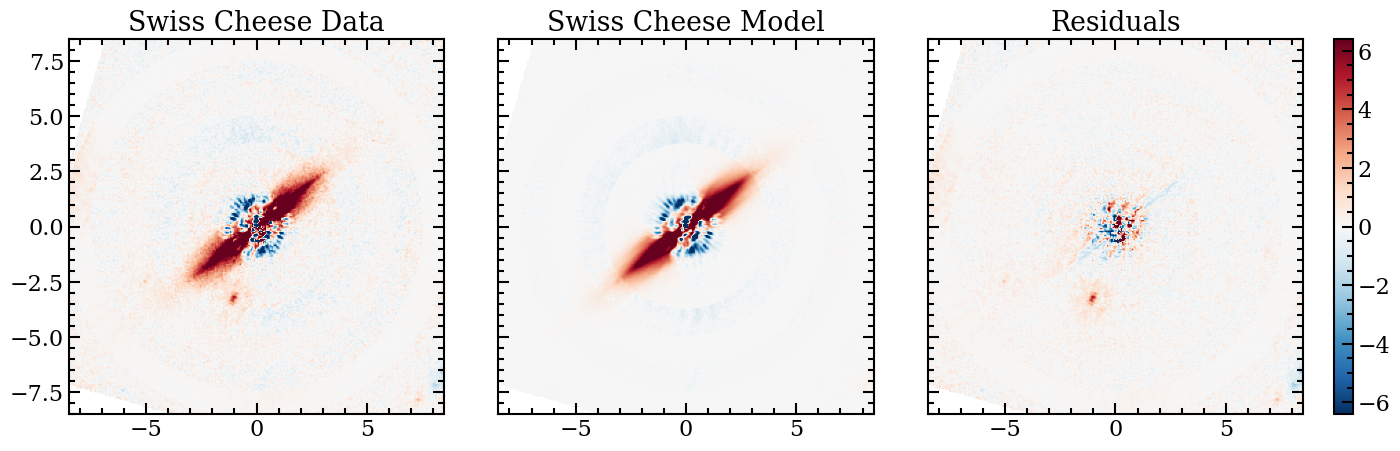

In [14]:
fig,axes,cbar = quick_implot([rdi_reduc3.im, fmrdi_reduc3.im, rdi_reduc3.im-fmrdi_reduc3.im], show=False, clim_perc=99.5, cmap='RdBu_r', extent=rdi_reduc.extent, show_ticks=True, lims=[-8.5,8.5],
                              cbar=True, cbar_kwargs=dict(pad=0.02), panelsize=(5.5,4.5))

for i,label in enumerate(['Swiss Cheese Data', 'Swiss Cheese Model', 'Residuals']):
    axes[i].set_title(label)
    
plt.show()

To be totally clear: the fact that forward modeling works for any set of optimization/subtraction zones does **not** mean that every set of zones provides the same information about the disk via forward modeling. As an extreme example: if every pixel is a separate "optimization zone" (nx times ny zones total), **any** forward-modeled disk would yield a perfect match for the PSF-subtracted data — with both being exactly zero. The choice of zones can bias and/or weaken your conclusions about a given disk.

### Let's look at a more informed use of zones.

Let's take a single annular optimization zone, but explicitly exclude the vicinity of the disk spine at both rolls from the optimization zone.

JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Mode: RDI (Winnie)
Extension for output files: 'rdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


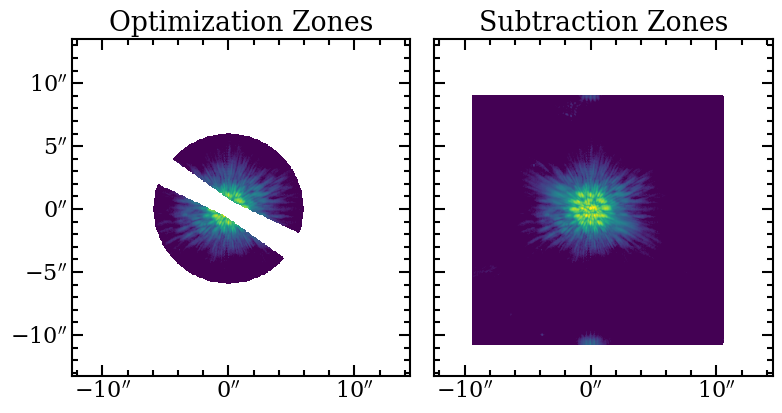

In [15]:
from photutils.aperture import RectangularAperture

optzones, subzones = winnie.rdi.build_annular_rdi_zones(wdb.nx, wdb.ny, wdb.c_star, r_opt=6*u.arcsec, pxscale=wdb.pxscale)
disk_pa = 128.48

for i,posang in enumerate(wdb._posangs_sci):
    excl = np.where(RectangularAperture(wdb.c_star, w=18, h=200, theta=(disk_pa-posang)*u.deg).to_mask().to_image([wdb.ny, wdb.nx]) > 0.5, True, False)
    optzones[:, excl] = False

wdb.set_zones(optzones, subzones)

wdb.report_current_config(show_plots=True)

In [16]:
# Run the RDI reduction for this zone

rdi_reduc4 = wdb.run_rdi()

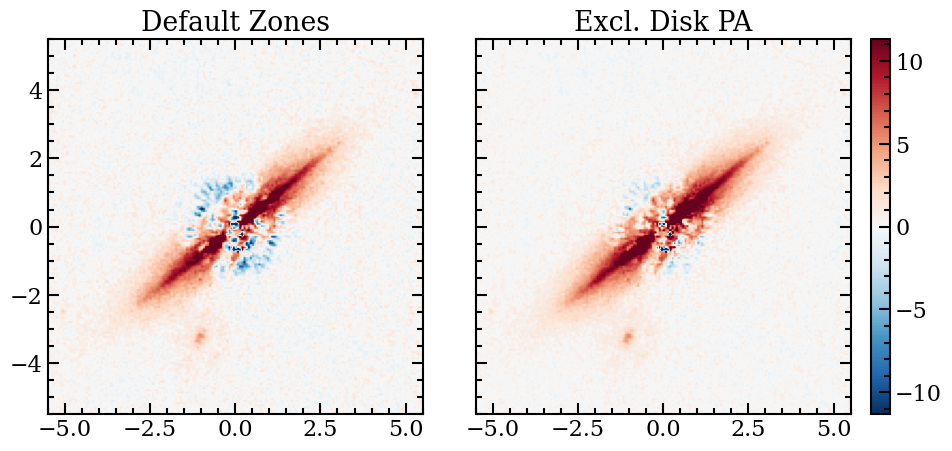

In [17]:
fig,axes,cbar = quick_implot([rdi_reduc.im, rdi_reduc4.im], show=False, clim_perc=99.8, cmap='RdBu_r', extent=rdi_reduc.extent, show_ticks=True, lims=[-5.5,5.5],
                              cbar=True, cbar_kwargs=dict(pad=0.02), panelsize=(5.5,4.5))

for i,label in enumerate(['Default Zones', 'Excl. Disk PA']):
    axes[i].set_title(label)
    
plt.show()

By explicitly excluding narrow regions along the disk PA, we have significantly diminished the oversubtraction at small separations (negative regions within r ~ 2 arcsec).

However, for any technique that avoids oversubtraction by masking circumstellar sources, there is a cost: we lose the information about the stellar PSF that falls in the masked region. This is especially impactful at small separations, where most of the stellar PSF variation occurs. E.g., imagine a nearly face-on disk with radius r ~ 1.5 arcsec. To exclude this disk from our optimization zones, we would also exclude the majority of the speckle-limited regime. This would very likely inhibit our sensitivity as small separations. 

In general, techniques like MCRDI and HPFRDI will likely yield better results. A good use-case, however, might be more complicated circumstellar scenes. For example: the case of Beta Pictoris. For MCRDI, we can model the circumstellar scene as the superposition of Beta Pic b and the disk (as in Rebollido et al. 2024) to avoid oversubtraction (and the separate the disk and planet signals). However, we could also ease the modeling burden some by simply masking out the location of Beta Pic b and fitting for a model of just the disk.

As a final note, I'll point out that one could also use this framework to search for planets using a LOCI-like procedure with a much larger number of opt/sub zones. As far as I'm aware, any benefits for this technique have not been demonstrated for JWST coronagraphy. Nevertheless: the option is there. 